<a href="https://colab.research.google.com/github/cbrf2002/cbrf2002-CollegeArchives/blob/main/4th%20year/ML/FINAL_FINAL_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Required Libraries
!pip install pyldavis transformers wordcloud seaborn nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.7 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, TextArea
import seaborn as sns
import pyLDAvis

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import pipeline
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud
from datetime import datetime
from google.colab import files, drive

# Enable pyLDAvis in notebooks
pyLDAvis.enable_notebook()

# NLTK Downloads
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


True

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [ ]:
# CONFIGURABLE VARIABLES
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/testdb_mod.csv'
ENCODING_TYPE = 'utf-8'  # Encoding for reading the file

# Column Configuration
COLUMN_TEXT = 'Reports'          # Column containing the text data such as reasons
COLUMN_GENRE = 'Genre'    # Column containing the genre or offense type
COLUMN_DATE = 'date'          # Column for date if available
COLUMN_CLEANED_TEXT = 'cleaned_reports'

# GPU/CPU Configuration
DEVICE = 0 if torch.cuda.is_available() else -1  # 0 for GPU, -1 for CPU

# PLOT SETTINGS
PLOT_COLOR = 'viridis'
PLOT_FONT = 'serif'
PLOT_FIGSIZE = (8, 5)
PLOT_BINS = 20
PLOT_TITLE = 'Distribution of Sentiment Scores'
PLOT_XLABEL = 'Sentiment Score'
PLOT_YLABEL = 'Frequency'

# Load Dataset
df = pd.read_csv(DATASET_PATH, encoding=ENCODING_TYPE)
num_samples = min(5000, len(df))
sampled_df = df.sample(n=num_samples, random_state=42)
df = sampled_df.copy()

# Check Data
df.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Genre,Reports
926,Food and Cantines,"2. ""I wish there were more vegan options in th..."
630,International student experiences,"21. ""It can be difficult to find common ground..."
682,Online learning,The increased screen time from online classes ...
514,Health and Well-being Support,It's frustrating that mental health care is st...
365,Career opportunities,I have been struggling to find job opportuniti...


In [ ]:
# PREPROCESSING STAGE
# CONFIGURATION
STOP_WORDS = set(stopwords.words('english'))
MIN_WORD_LENGTH = 3  # Minimum length of tokens to retain

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Cleans and preprocesses text by removing special characters, digits,
    stopwords, and lemmatizing tokens.
    """
    if not isinstance(text, str):
        text = str(text)

    # Remove special characters, digits, and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)      # Remove digits
    text = text.lower()                  # Convert to lowercase

    # Tokenization and stopword removal
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOP_WORDS and len(word) >= MIN_WORD_LENGTH]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply preprocessing to the text column
df[COLUMN_CLEANED_TEXT] = df[COLUMN_TEXT].apply(preprocess_text)
df.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Genre,Reports,cleaned_reports
926,Food and Cantines,"2. ""I wish there were more vegan options in th...",wish vegan option cafeteria
630,International student experiences,"21. ""It can be difficult to find common ground...",difficult find common ground people vastly dif...
682,Online learning,The increased screen time from online classes ...,increased screen time online class cause eye s...
514,Health and Well-being Support,It's frustrating that mental health care is st...,frustrating mental health care still stigmatiz...
365,Career opportunities,I have been struggling to find job opportuniti...,struggling find job opportunity pay fair wage ...


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Load Pretrained Model and Tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
labels = ["negative", "neutral", "positive"]

# GPU/CPU Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function for Batched Sentiment Analysis
def analyze_sentiments(texts, batch_size=16):
    """
    Perform sentiment analysis on a batch of texts.
    Args:
        texts (list of str): The input texts to analyze.
        batch_size (int): The batch size for processing.
    Returns:
        scores (list of float): The sentiment scores for each text.
        sentiments (list of str): The sentiment labels for each text.
    """
    scores = []
    sentiments = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Tokenize and move to device
        encoded_input = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        encoded_input = {key: tensor.to(device) for key, tensor in encoded_input.items()}

        # Model prediction
        with torch.no_grad():
            output = model(**encoded_input)

        # Softmax probabilities
        batch_scores = softmax(output.logits.cpu().numpy(), axis=1)

        for probs in batch_scores:
            max_idx = np.argmax(probs)
            scores.append(probs[max_idx])
            sentiments.append(labels[max_idx])

    return scores, sentiments

# Apply to DataFrame
sentiment_scores, sentiment_labels = analyze_sentiments(texts, batch_size=32)

# Add Results to DataFrame
df['sentiment_score'] = sentiment_scores
df['Sentiment'] = sentiment_labels

# Preview results
print(df.head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

                                 Genre  \
926                  Food and Cantines   
630  International student experiences   
682                    Online learning   
514      Health and Well-being Support   
365               Career opportunities   

                                               Reports  \
926  2. "I wish there were more vegan options in th...   
630  21. "It can be difficult to find common ground...   
682  The increased screen time from online classes ...   
514  It's frustrating that mental health care is st...   
365  I have been struggling to find job opportuniti...   

                                       cleaned_reports  sentiment_score  \
926                        wish vegan option cafeteria         0.560968   
630  difficult find common ground people vastly dif...         0.553550   
682  increased screen time online class cause eye s...         0.568483   
514  frustrating mental health care still stigmatiz...         0.922232   
365  struggling find jo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-118-807da2c982fa>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


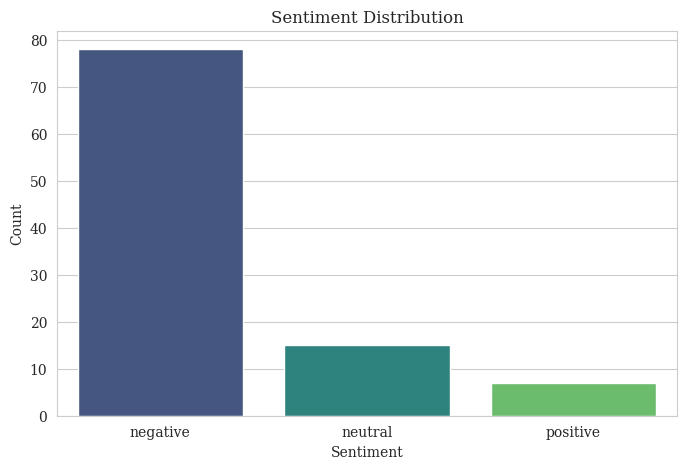

In [ ]:
# Count occurrences of each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Visualization
plt.figure(figsize=(8, 5))
sentiment_counts = df['Sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns

# Load Pretrained Emotion Model
EMOTION_MODEL = "j-hartmann/emotion-english-distilroberta-base"
emotion_tokenizer = AutoTokenizer.from_pretrained(EMOTION_MODEL)
emotion_model = AutoModelForSequenceClassification.from_pretrained(EMOTION_MODEL)
emotion_labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

# Load Pretrained Sentiment Model
SENTIMENT_MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_tokenizer = AutoTokenizer.from_pretrained(SENTIMENT_MODEL)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(SENTIMENT_MODEL)
sentiment_labels = ["negative", "neutral", "positive"]

# Move models to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_model.to(device)
sentiment_model.to(device)

# Function for Emotion Analysis
def analyze_emotions(texts, batch_size=16):
    emotion_scores = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Tokenize and move to device
        encoded_input = emotion_tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        encoded_input = {key: tensor.to(device) for key, tensor in encoded_input.items()}

        # Model prediction
        with torch.no_grad():
            output = emotion_model(**encoded_input)

        # Softmax probabilities
        batch_scores = softmax(output.logits.cpu().numpy(), axis=1)

        for probs in batch_scores:
            emotion_scores.append(dict(zip(emotion_labels, probs)))

    return emotion_scores

# Function for Sentiment Analysis
def analyze_sentiments(texts, batch_size=16):
    sentiment_scores = []
    sentiment_results = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Tokenize and move to device
        encoded_input = sentiment_tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        encoded_input = {key: tensor.to(device) for key, tensor in encoded_input.items()}

        # Model prediction
        with torch.no_grad():
            output = sentiment_model(**encoded_input)

        # Softmax probabilities
        batch_scores = softmax(output.logits.cpu().numpy(), axis=1)

        for probs in batch_scores:
            sentiment_scores.append(dict(zip(sentiment_labels, probs)))
            sentiment_results.append(sentiment_labels[np.argmax(probs)])

    return sentiment_scores, sentiment_results

# Analyze Data
df['emotion_scores'] = analyze_emotions(df[COLUMN_CLEANED_TEXT].tolist(), batch_size=32)
df['dominant_emotion'] = df['emotion_scores'].apply(lambda x: max(x, key=x.get))

sentiment_scores, sentiment_labels = analyze_sentiments(df[COLUMN_CLEANED_TEXT].tolist(), batch_size=32)
df['sentiment_scores'] = sentiment_scores
df['Sentiment'] = sentiment_labels

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-14-2293ac15324a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, ax=axes[0], palette="viridis")
<ipython-input-14-2293ac15324a>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=axes[1], palette="viridis")


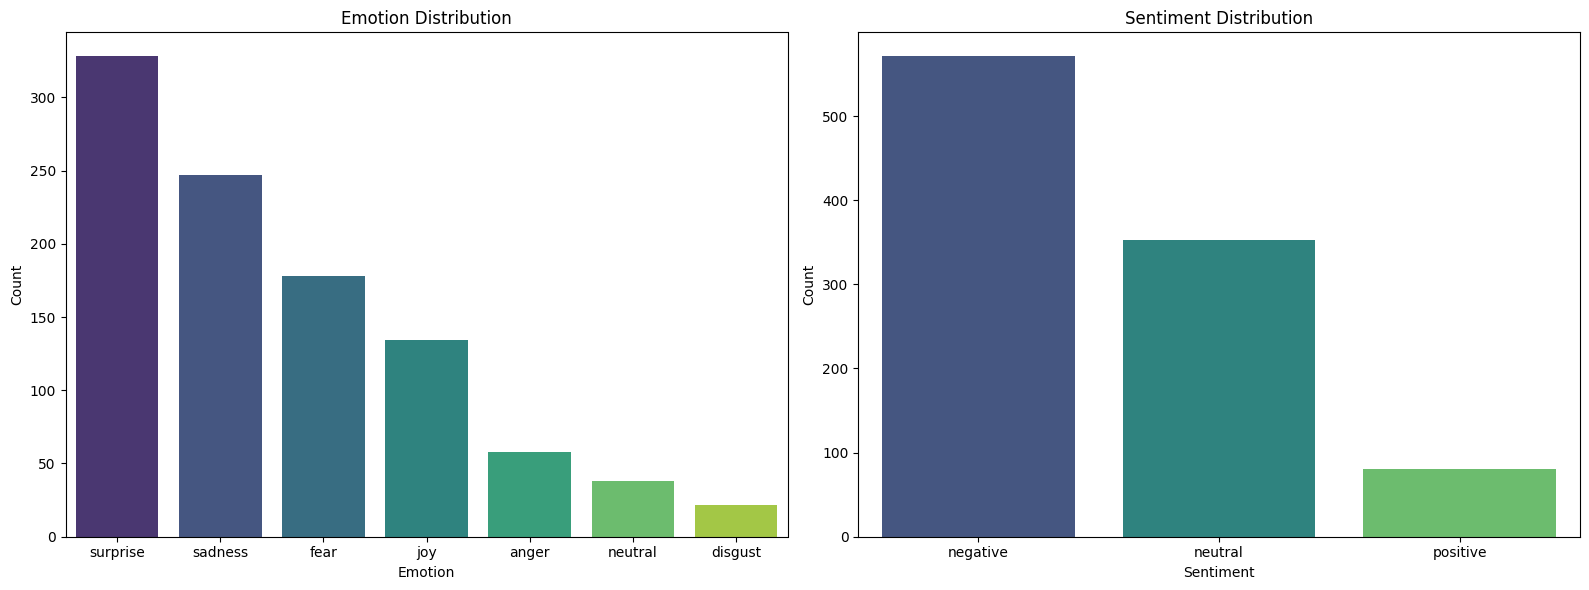

In [ ]:
# Visualization
# Emotion Distribution
emotion_counts = df['dominant_emotion'].value_counts()
sentiment_counts = df['Sentiment'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Emotion Plot
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Emotion Distribution")
axes[0].set_xlabel("Emotion")
axes[0].set_ylabel("Count")

# Sentiment Plot
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=axes[1], palette="viridis")
axes[1].set_title("Sentiment Distribution")
axes[1].set_xlabel("Sentiment")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Genre,Reports
926,Food and Cantines,"2. ""I wish there were more vegan options in th..."
630,International student experiences,"21. ""It can be difficult to find common ground..."
682,Online learning,The increased screen time from online classes ...
514,Health and Well-being Support,It's frustrating that mental health care is st...
365,Career opportunities,I have been struggling to find job opportuniti...


In [ ]:
# K-MEANS CLUSTER VECTORIZATION AND VISUALIZATION
# CONFIGURATION
N_CLUSTERS = 5
MAX_FEATURES = 1000

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
X = vectorizer.fit_transform(df[COLUMN_CLEANED_TEXT])

# K-Means Clustering
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X.toarray())

# Create a DataFrame for Visualization
visualization_df = pd.DataFrame({
    'PCA1': reduced_features[:, 0],
    'PCA2': reduced_features[:, 1],
    'Cluster': df['Cluster']
})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


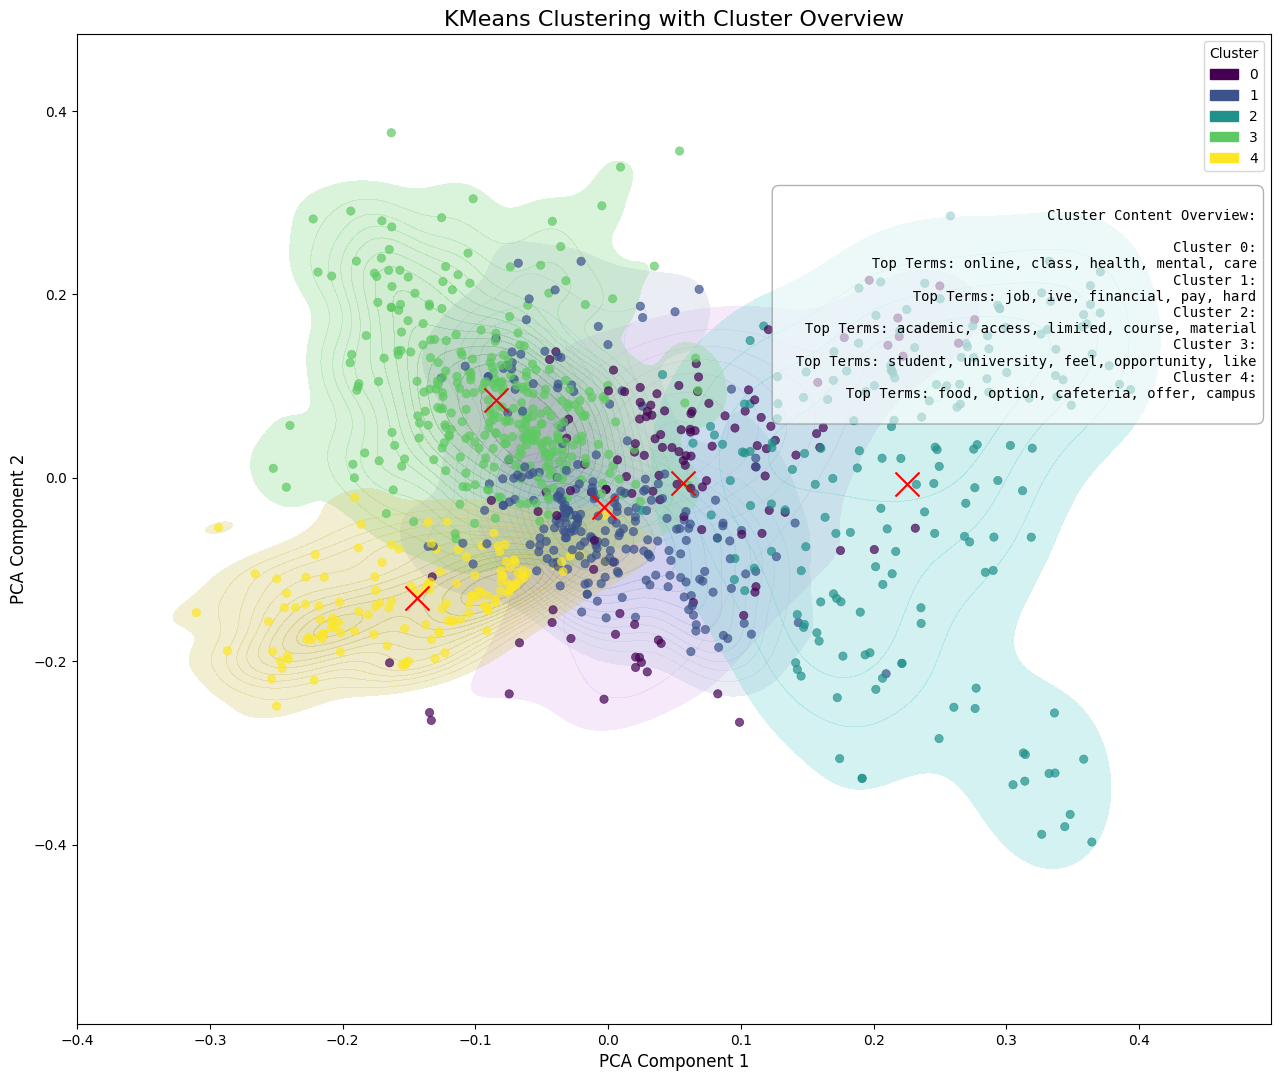

In [ ]:
# Plot Clusters with Density Contours
plt.figure(figsize=(14, 12))

sns.kdeplot(
    data=visualization_df,
    x='PCA1', y='PCA2',
    hue='Cluster',
    fill=True, alpha=0.3,
    levels=15, palette=PLOT_COLOR
)

sns.scatterplot(
    data=visualization_df,
    x='PCA1', y='PCA2',
    hue='Cluster',
    palette=PLOT_COLOR, alpha=0.7, edgecolor=None, legend=False
)

# Annotate Centroids
centroids = pca.transform(kmeans.cluster_centers_)
for i, (x, y) in enumerate(centroids):
    plt.scatter(x, y, c='red', marker='x', s=300, label=f'Centroid {i}')

# Add Titles and Labels
plt.title('KMeans Clustering with Cluster Overview', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

# Cluster Content Overview as Part of the Plot
content_overview = "\nCluster Content Overview:\n\n"
for cluster in range(kmeans.n_clusters):
    top_indices = kmeans.cluster_centers_[cluster].argsort()[-5:][::-1]  # Reduce top terms count
    top_terms = [vectorizer.get_feature_names_out()[i] for i in top_indices]
    content_overview += f"Cluster {cluster}:\n"
    content_overview += f"  Top Terms: {', '.join(top_terms)}\n"

# Add text box as part of the plot with right alignment
plt.figtext(0.94, 0.79, content_overview, fontsize=10, family='monospace', va='top', ha='right',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.6))

# Increase figure size and layout adjustments
plt.tight_layout(pad=5.0)  # Increase padding between elements
plt.show()

In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Genre,Reports
926,Food and Cantines,"2. ""I wish there were more vegan options in th..."
630,International student experiences,"21. ""It can be difficult to find common ground..."
682,Online learning,The increased screen time from online classes ...
514,Health and Well-being Support,It's frustrating that mental health care is st...
365,Career opportunities,I have been struggling to find job opportuniti...


In [ ]:
# Required Libraries
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from wordcloud import WordCloud

# Topic Configuration
N_TOPICS = 6
N_TOP_WORDS = 5

# Vectorize Text (TF-IDF)
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X = vectorizer.fit_transform(df[COLUMN_CLEANED_TEXT])

# Fit NMF Model
nmf = NMF(n_components=N_TOPICS, random_state=42, max_iter=300)
nmf.fit(X)

# Extract Vocabulary and Topic Distributions
vocab = np.array(vectorizer.get_feature_names_out())
topics = nmf.components_  # Shape: (n_topics, n_features)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


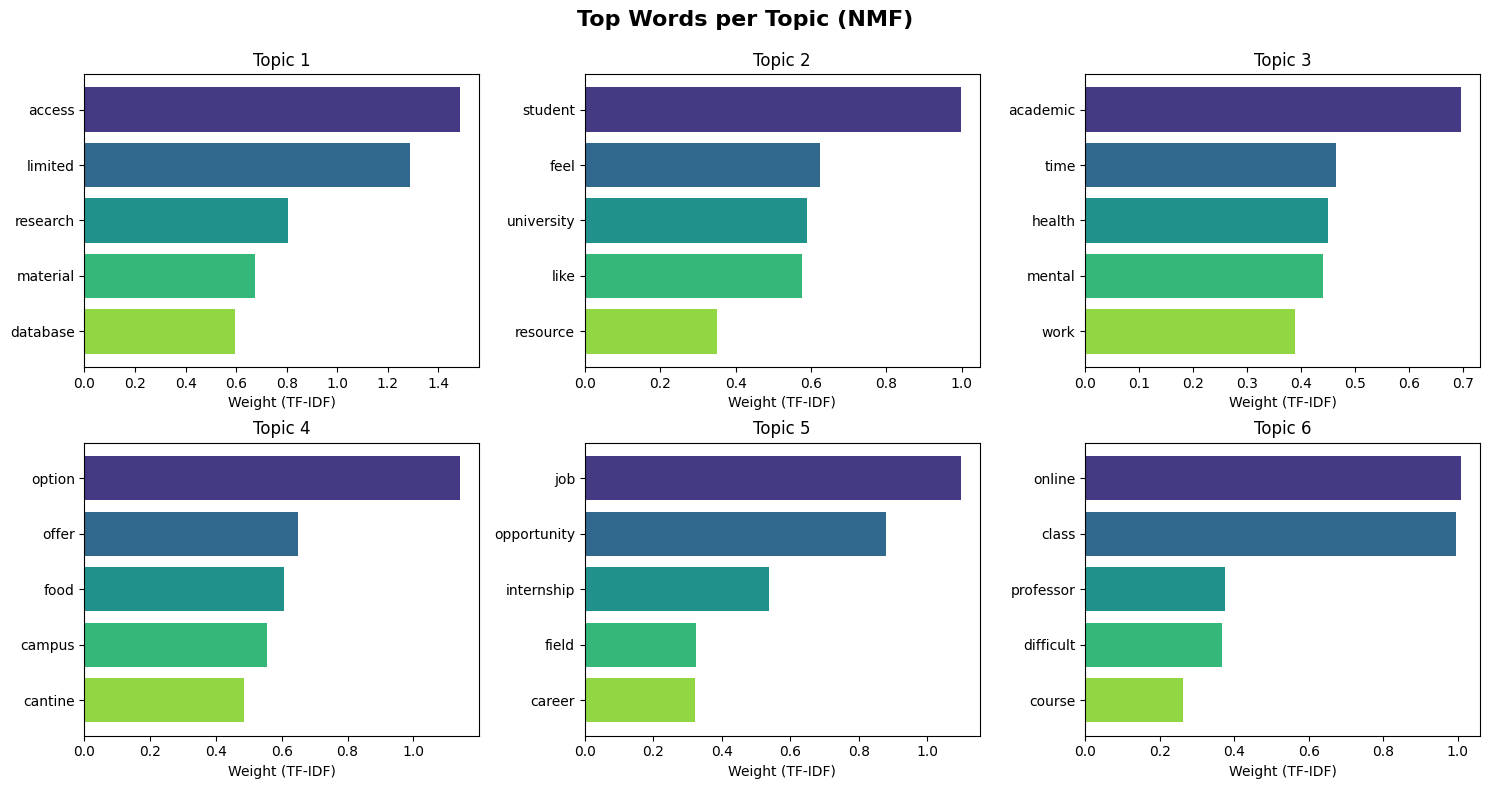

In [ ]:
# Prepare Top Words and Probabilities
topic_data = []
for idx, topic in enumerate(topics):
    top_indices = topic.argsort()[-N_TOP_WORDS:][::-1]
    top_words = [(vocab[i], topic[i]) for i in top_indices]
    topic_data.append((f"Topic {idx + 1}", top_words))

# Plot Top Words for Each Topic
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # Adjusted layout
axs = axs.flatten()

for ax, (title, words_probs) in zip(axs, topic_data):
    words, probs = zip(*words_probs)
    colors = sns.color_palette(PLOT_COLOR, n_colors=len(words))
    ax.barh(words, probs, color=colors)
    ax.set_title(title)
    ax.set_xlabel("Weight (TF-IDF)")
    ax.invert_yaxis()

plt.tight_layout()
plt.suptitle("Top Words per Topic (NMF)", fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.9)
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Generating WordClouds for Topics...


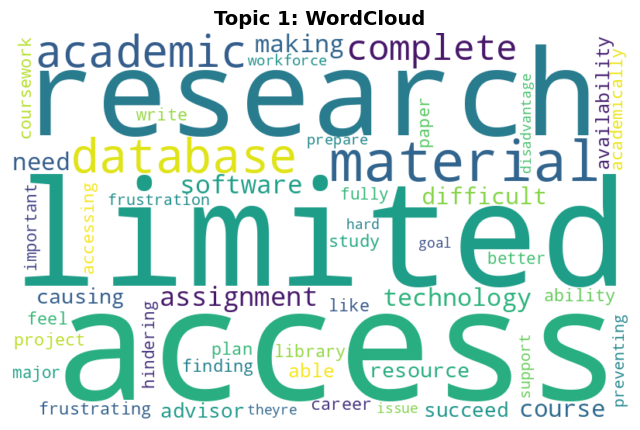

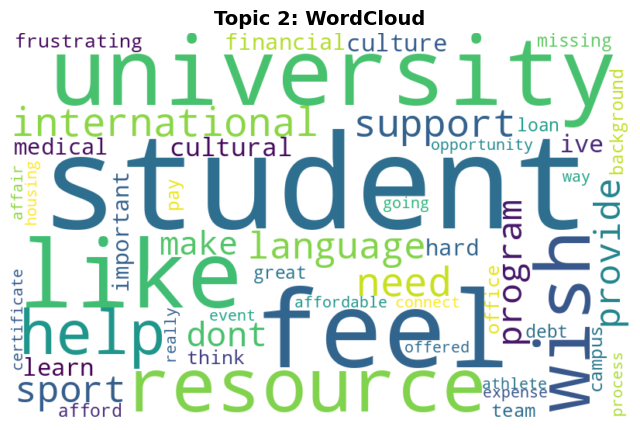

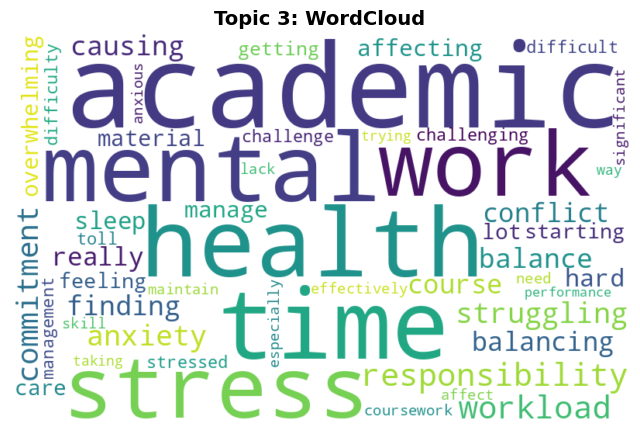

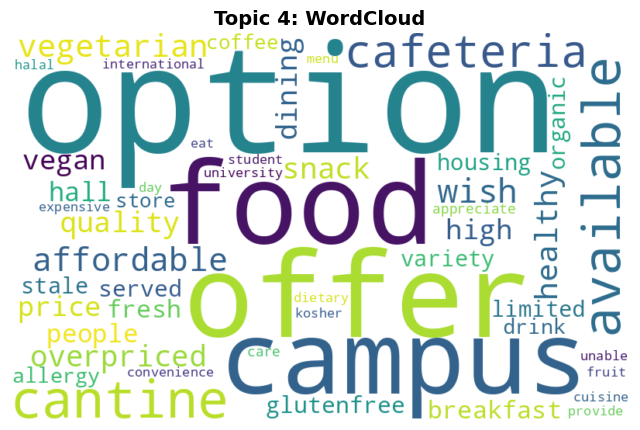

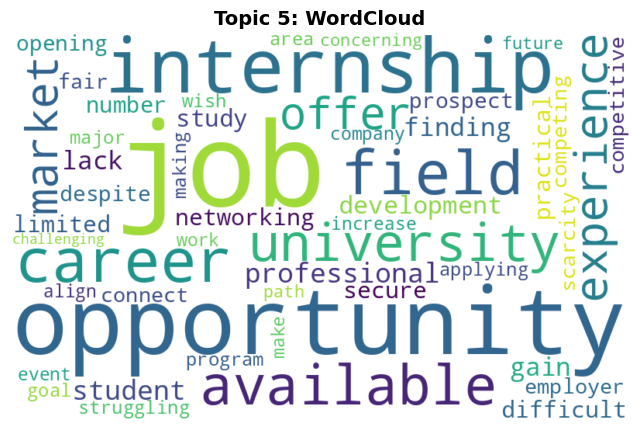

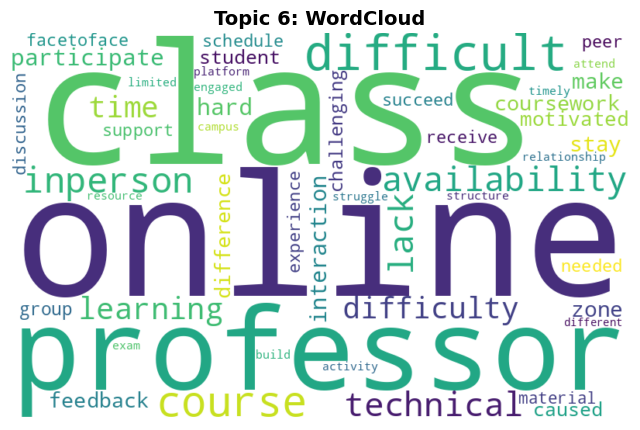

In [ ]:

# Visualization 2: WordCloud of Most Salient Terms
print("Generating WordClouds for Topics...")
for idx, topic in enumerate(topics):
    top_indices = topic.argsort()[-50:][::-1]
    top_words = {vocab[i]: topic[i] for i in top_indices}

    wordcloud = WordCloud(width=800, height=500, background_color="white",
                          colormap=PLOT_COLOR).generate_from_frequencies(top_words)

    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {idx + 1}: WordCloud", fontsize=14, fontweight='bold')
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Generating Intertopic Distance Map...


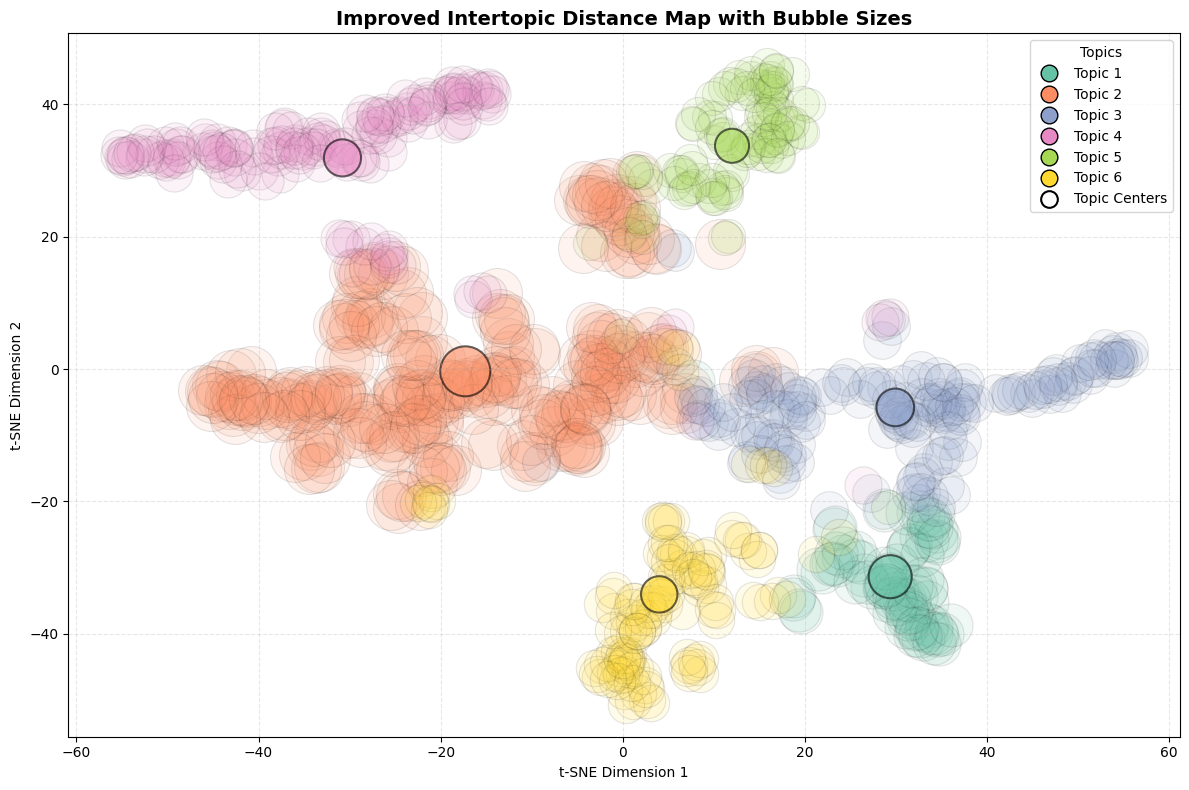

In [ ]:
# Visualization 3: Intertopic Distance Map (t-SNE)
print("Generating Intertopic Distance Map...")
# Step 1: Calculate Topic Proportions
topic_proportions = topics.sum(axis=1)
topic_proportions = topic_proportions / topic_proportions.sum()  # Normalize topic weights

# Step 2: Refined t-SNE Projection of Topics
topic_weights = nmf.transform(X)  # Get topic distributions for all documents
tsne = TSNE(n_components=2, random_state=42, perplexity=20, learning_rate=200)
topic_proj = tsne.fit_transform(topic_weights)

# Step 3: Visualize with Improved Jitter and Circle Clarity
plt.figure(figsize=(12, 8))

# Bubble sizes and colors
bubble_size = topic_proportions * 5000  # Scale bubble size
colors = sns.color_palette("Set2", n_colors=N_TOPICS)

# Plot each topic
for i in range(N_TOPICS):
    x = topic_proj[:, 0][topic_weights.argmax(axis=1) == i]
    y = topic_proj[:, 1][topic_weights.argmax(axis=1) == i]
    plt.scatter(
        x + np.random.normal(0, 0.5, size=len(x)),  # Jitter X-axis
        y + np.random.normal(0, 0.5, size=len(y)),  # Jitter Y-axis
        s=bubble_size[i],
        color=colors[i],
        alpha=0.1,
        edgecolors='black',
        linewidth=0.8,
        label=f"Topic {i+1}"
    )

# Highlight topic centers with larger markers
topic_centers = np.array([topic_proj[topic_weights.argmax(axis=1) == i].mean(axis=0) for i in range(N_TOPICS)])
topic_labels = [f"Topic {i+1}" for i in range(N_TOPICS)]
topic_labels.append("Topic Centers")

plt.scatter(
    topic_centers[:, 0],
    topic_centers[:, 1],
    s=bubble_size,
    c=colors,
    alpha=0.6,
    edgecolors='black',
    linewidth=1.5,
    marker='o',
    label="Topic Centers",
)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color if label != "Topic Centers" else 'white', markeredgecolor='black', markeredgewidth=1 if label != "Topic Centers" else 1.5, markersize=12, alpha=1.0)
    for label, color in zip(topic_labels, colors + [colors[-1]])
]
plt.legend(handles=legend_elements, loc="upper right", title="Topics")

# Final Formatting
plt.title("Improved Intertopic Distance Map with Bubble Sizes", fontsize=14, fontweight='bold')
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-55-c565cabd1b05>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=salient_counts, y=salient_words, palette=PLOT_COLOR)


Generating Bar Chart for Most Salient Terms...


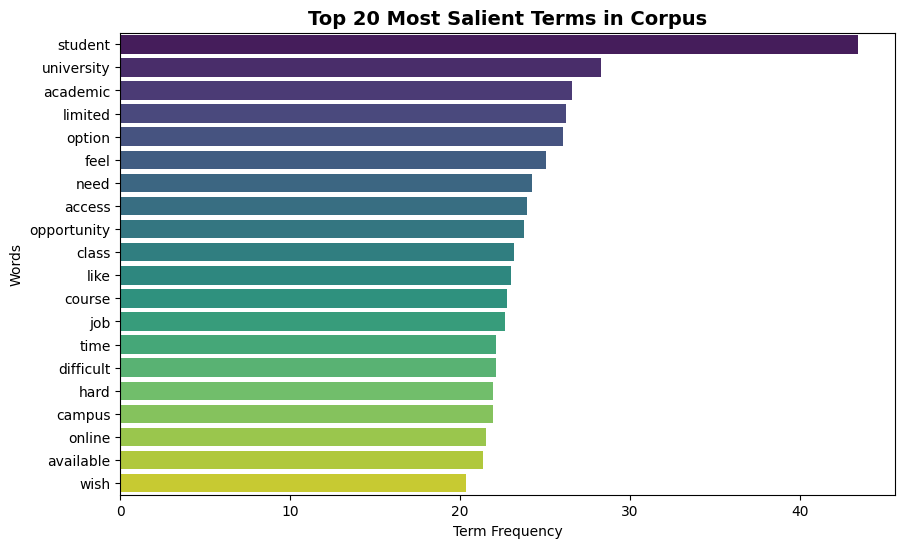

In [ ]:
# Visualization 4: Most Salient Terms
print("Generating Bar Chart for Most Salient Terms...")
word_freq = np.array(X.sum(axis=0)).flatten()
sorted_indices = word_freq.argsort()[-20:][::-1]
salient_words = vocab[sorted_indices]
salient_counts = word_freq[sorted_indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=salient_counts, y=salient_words, palette=PLOT_COLOR)
plt.title("Top 20 Most Salient Terms in Corpus", fontsize=14, fontweight='bold')
plt.xlabel("Term Frequency")
plt.ylabel("Words")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


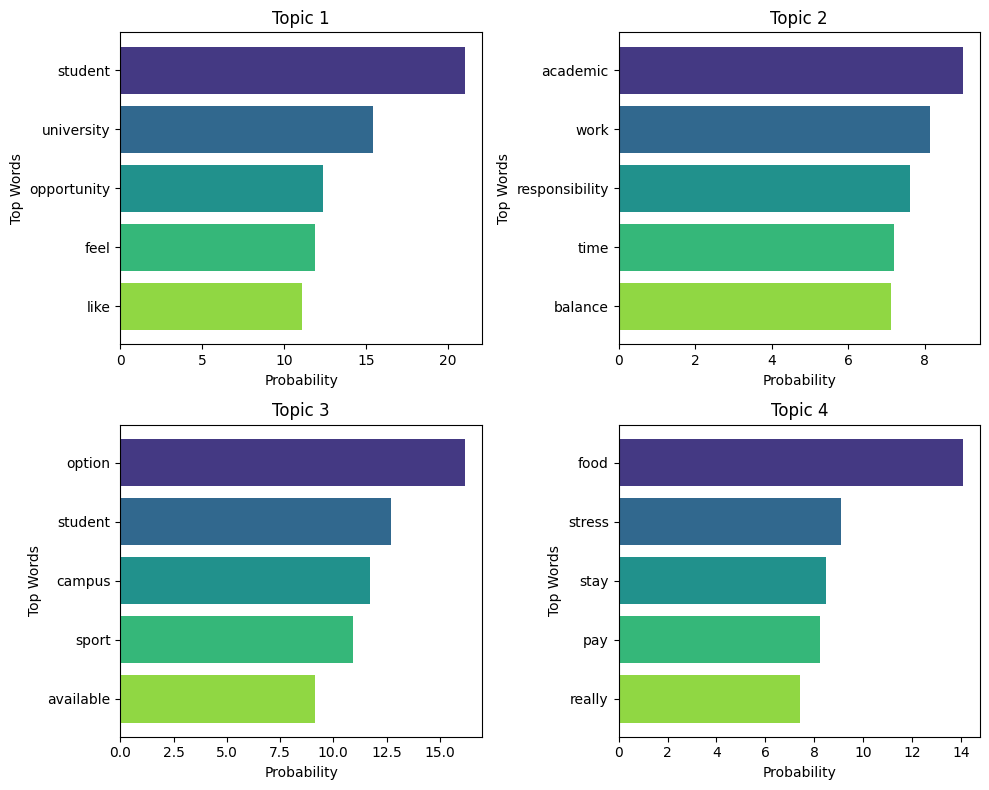

In [ ]:
# TOPIC MODELING USING LDA
# CONFIGURATION
N_TOPICS = 5
N_TOP_WORDS = 5

# Fit LDA model
lda = LatentDirichletAllocation(n_components=N_TOPICS, random_state=42)
lda.fit(X)

# Extract Vocabulary and Topic Distributions
vocab = vectorizer.get_feature_names_out()
topics = lda.components_  # Shape: (n_topics, n_features)

# Prepare Top Words and Probabilities
topic_data = []
for idx, topic in enumerate(topics):
    top_indices = topic.argsort()[-N_TOP_WORDS:][::-1]
    top_words = [(vocab[i], topic[i]) for i in top_indices]
    topic_data.append((f"Topic {idx + 1}", top_words))

# Plot Topics
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for ax, (title, words_probs) in zip(axs.flatten(), topic_data):
    words, probs = zip(*words_probs)
    colors = sns.color_palette(PLOT_COLOR, n_colors=len(words))
    ax.barh(words, probs, color=colors)
    ax.set_title(title)
    ax.set_xlabel("Probability")
    ax.set_ylabel("Top Words")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/pyth

,precision,recall,f1-score,support
0,1.000,0.750,0.857,4.0
2,1.000,0.600,0.750,5.0
3,0.333,1.000,0.500,1.0
4,0.000,0.000,0.000,1.0
5,0.429,1.000,0.600,3.0
6,0.000,0.000,0.000,0.0
7,0.000,0.000,0.000,3.0
8,1.000,0.500,0.667,2.0
9,1.000,1.000,1.000,1.0
accuracy,0.600,0.600,0.600,0.6


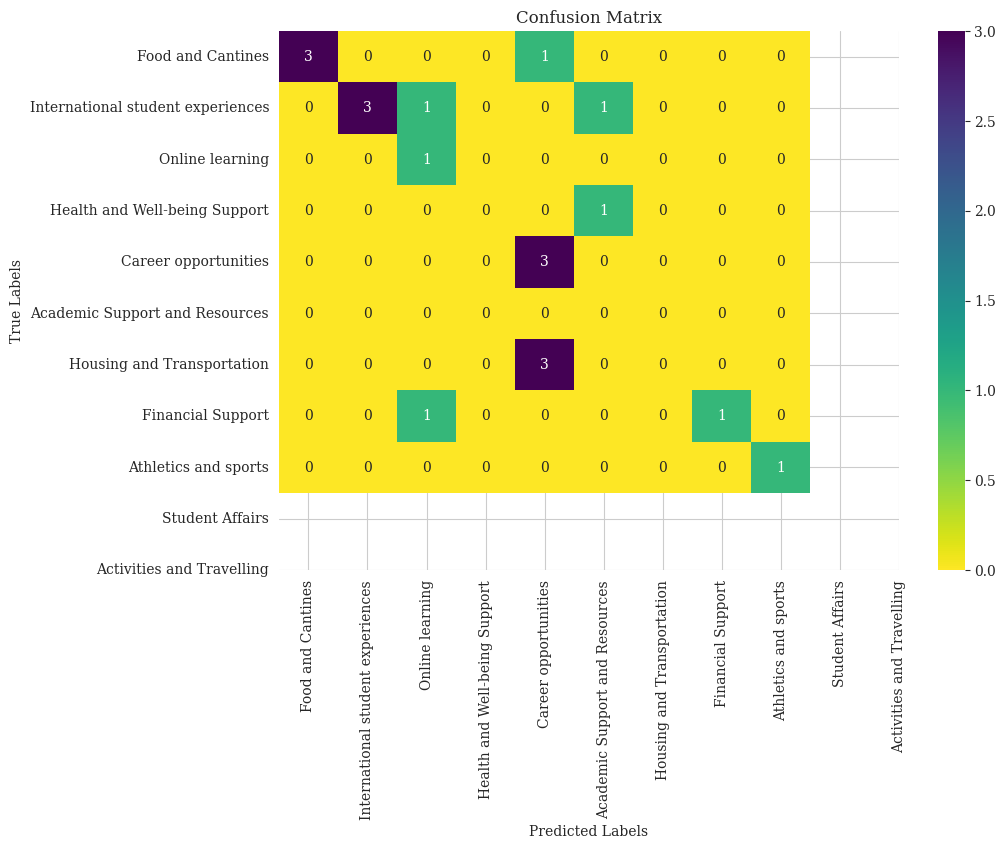

In [ ]:
# PREDICTIVE MODELING USING RANDOM FOREST WITH CONFUSION MATRIX VIS
# Encode Genre as Labels
df['offense_label'] = df[COLUMN_GENRE].astype('category').cat.codes

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df['offense_label'], test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test)
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(3)

from IPython.display import display
display(report_df)

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis_r", xticklabels=df[COLUMN_GENRE].unique(), yticklabels=df[COLUMN_GENRE].unique())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


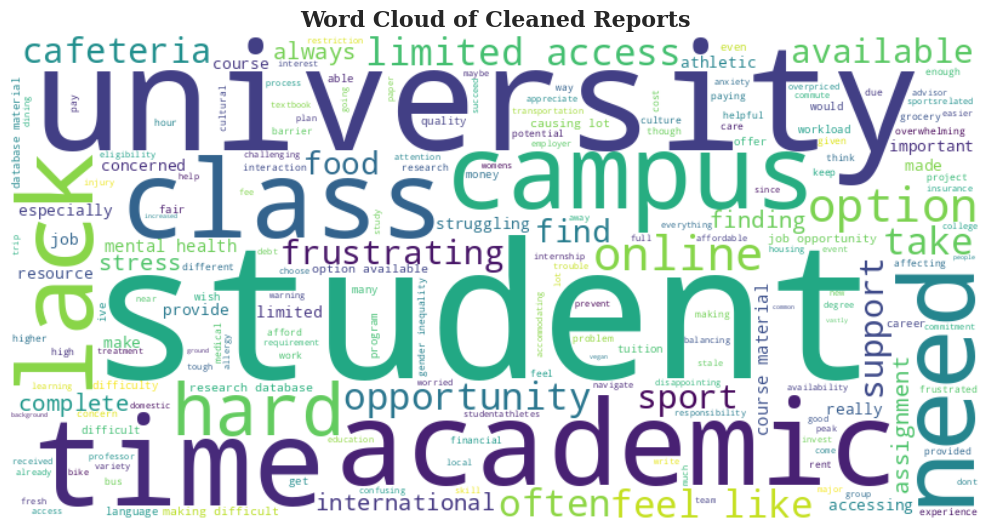

In [ ]:
from wordcloud import WordCloud
# Generate Word Cloud
wordcloud_text = ' '.join(df[COLUMN_CLEANED_TEXT])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap=PLOT_COLOR,
    stopwords=STOP_WORDS,
    max_words=200
).generate(wordcloud_text)

# Display Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Reports", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## TEST

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.nn.functional import softmax

class TransformerSequenceClassifier:
    def __init__(self, model_name='distilbert-base-uncased', num_labels=5):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )

    def predict(self, texts):
        # Tokenize and predict probabilities
        inputs = self.tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
        outputs = self.model(**inputs)
        probabilities = softmax(outputs.logits, dim=1)
        return probabilities

        # Convert probabilities to labels
        predicted_labels = torch.argmax(probabilities, dim=1)
        return predicted_labels.tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# TF-IDF for cleaned reports
tfidf = TfidfVectorizer(max_features=500)
tfidf_features = tfidf.fit_transform(df['cleaned_reports']).toarray()

# Combine features into a DataFrame
X = pd.DataFrame(tfidf_features)
X['predicted_label'] = df['predicted_label']
X['sentiment_score'] = df['sentiment_score']
X.columns = X.columns.astype(str)

# Target variable
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest with class weights
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predictions and metrics
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis_r", xticklabels=y.unique(), yticklabels=y.unique())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: 'predicted_label'

In [ ]:
# SENTIMENT ANALYSIS USING PRE-TRAINED BERT MODEL
# Initialize the sentiment analysis pipeline
sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    device=DEVICE
)

def analyze_sentiments_in_batches(texts):
    """Analyzes sentiment for a list of texts in batches."""
    try:
        # Ensure text fits model's max token length
        truncated_texts = [text[:512] if len(text) > 512 else text for text in texts]
        results = sentiment_model(truncated_texts)
        # Convert results to sentiment scores
        scores = [
            res['score'] if res['label'] == 'POSITIVE' else -res['score']
            for res in results
        ]
        return scores
    except Exception as e:
        print(f"Error during batch processing: {e}")
        return [0.0] * len(texts)  # Return neutral scores for failed texts

# Apply batch sentiment analysis to the dataframe
batch_size = 32  # Define the batch size
texts = df[COLUMN_TEXT].tolist()  # Extract texts as a list

# Process the data in batches
sentiment_scores = []
for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    batch_scores = analyze_sentiments_in_batches(batch)
    sentiment_scores.extend(batch_scores)

# Add the scores back to the DataFrame
df['sentiment_score'] = sentiment_scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


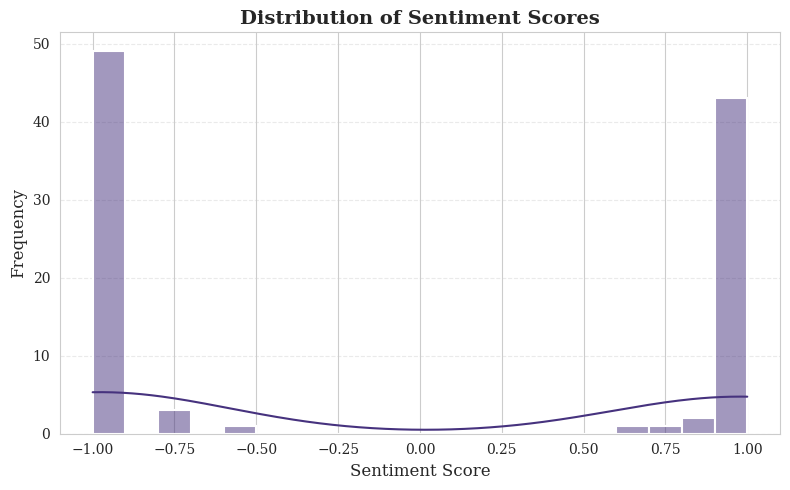

In [ ]:
# Visualization: Sentiment Distribution

sns.set_style('whitegrid')
plt.rcParams.update({'font.family': PLOT_FONT})

plt.figure(figsize=PLOT_FIGSIZE)
sns.histplot(
    df['sentiment_score'],
    bins=PLOT_BINS,
    kde=True,
    color=sns.color_palette(PLOT_COLOR)[0],
    linewidth=1.5
)
plt.title(PLOT_TITLE, fontsize=14, fontweight='bold')
plt.xlabel(PLOT_XLABEL, fontsize=12)
plt.ylabel(PLOT_YLABEL, fontsize=12)
#plt.xticks(fontsize=10)
#plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


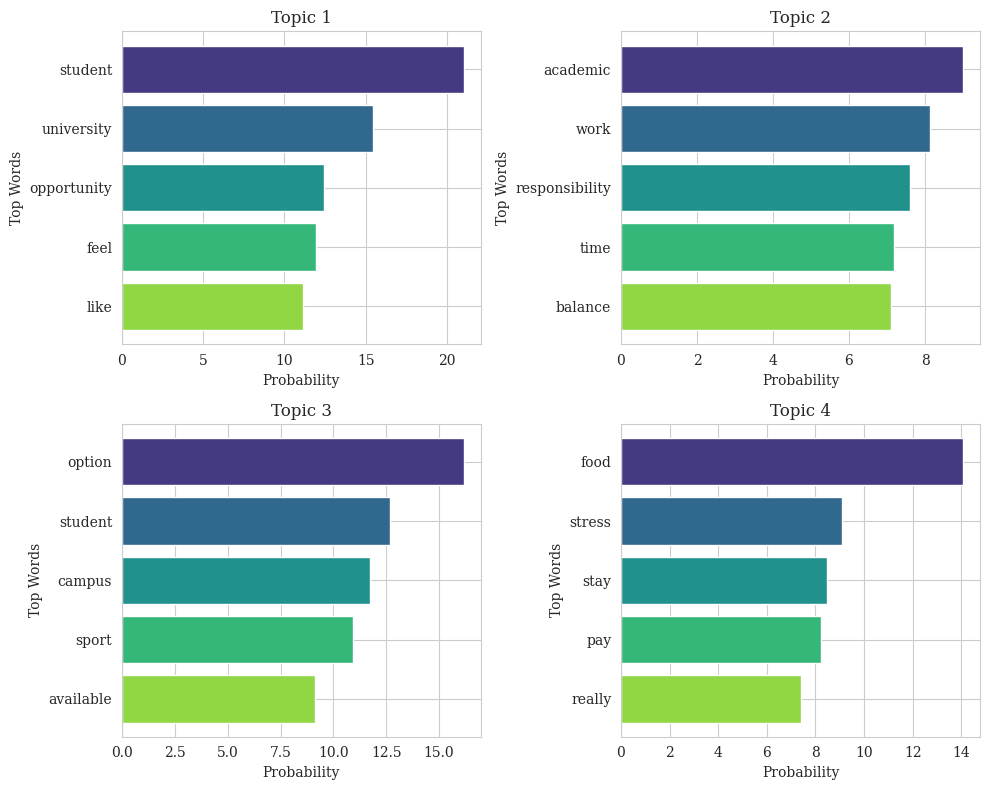

In [ ]:
# TOPIC MODELING USING LDA
# CONFIGURATION
N_TOPICS = 5
N_TOP_WORDS = 5

# Fit LDA model
lda = LatentDirichletAllocation(n_components=N_TOPICS, random_state=42)
lda.fit(X)

# Extract Vocabulary and Topic Distributions
vocab = vectorizer.get_feature_names_out()
topics = lda.components_  # Shape: (n_topics, n_features)

# Prepare Top Words and Probabilities
topic_data = []
for idx, topic in enumerate(topics):
    top_indices = topic.argsort()[-N_TOP_WORDS:][::-1]
    top_words = [(vocab[i], topic[i]) for i in top_indices]
    topic_data.append((f"Topic {idx + 1}", top_words))

# Plot Topics
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for ax, (title, words_probs) in zip(axs.flatten(), topic_data):
    words, probs = zip(*words_probs)
    colors = sns.color_palette(PLOT_COLOR, n_colors=len(words))
    ax.barh(words, probs, color=colors)
    ax.set_title(title)
    ax.set_xlabel("Probability")
    ax.set_ylabel("Top Words")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
!pip install hdbscan

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 29.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


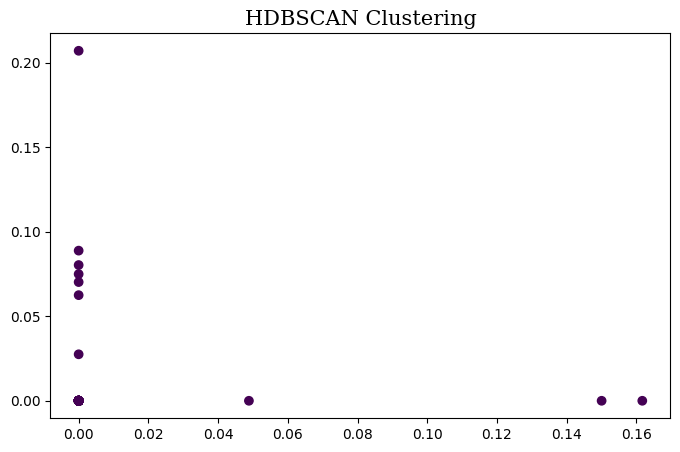

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import hdbscan
import matplotlib.pyplot as plt

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df[COLUMN_CLEANED_TEXT])

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
labels = clusterer.fit_predict(X.toarray())
df['Cluster'] = labels

# Visualization
plt.figure(figsize=PLOT_FIGSIZE)
plt.scatter(X.toarray()[:, 0], X.toarray()[:, 1], c=labels, cmap=PLOT_COLOR)
plt.title('HDBSCAN Clustering', fontsize=15, fontname=PLOT_FONT)
plt.show()


In [ ]:
# Map sentiment scores to labels
def map_sentiment(score):
    """Maps sentiment scores to labels."""
    if score > 0.5:  # Positive sentiment threshold
        return 'positive'
    elif score < -0.5:  # Negative sentiment threshold
        return 'negative'
    else:
        return 'neutral'

df['predicted_sentiment'] = df['sentiment_score'].apply(map_sentiment)

# Encode sentiment labels as numeric
df['sentiment_label'] = df[COLUMN_GENRE].astype('category').cat.codes
df['predicted_label'] = df['predicted_sentiment'].astype('category').cat.codes
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,review,sentiment,cleaned_reports,sentiment_score,predicted_sentiment,sentiment_label,predicted_label
33553,I really liked this Summerslam due to the look...,positive,really liked summerslam due look arena curtain...,0.692155,positive,1,1
9427,Not many television shows appeal to quite as m...,positive,many television show appeal quite many differe...,0.971069,positive,1,1
199,The film quickly gets to a major chase scene w...,negative,film quickly get major chase scene ever increa...,-0.996004,negative,0,0
12447,Jane Austen would definitely approve of this o...,positive,jane austen would definitely approve onebr gwy...,0.992226,positive,1,1
39489,Expectations were somewhat high for me when I ...,negative,expectation somewhat high went see movie thoug...,-0.988726,negative,0,0


In [ ]:
print(df['sentiment_label'].value_counts())
print(df['predicted_label'].value_counts())

sentiment_label
1    52
0    48
Name: count, dtype: int64
predicted_label
0    66
1    34
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
